In [151]:
import numpy as np
from tqdm.contrib.itertools import product
a = np.load("experiment/metrics/survivability/collision_states_6m_12s_RVO.npy")

index = 0
metric_dict = {}
round_metrics_dict = {}

for map_id in range(20):
    for (agent_num, agent_size, agent_vel) in product([10, 20, 30], [5, 10, 15], [20, 40, 60]):
        survive_times = []
        for start_time in range(0, 240, 40):
            survive_time = 0
            while (start_time + survive_time < 240) and (not (a[index,::2,::2,start_time+survive_time].any())):
                survive_time += 1
            survive_times.append(survive_time)
        metric_dict[(map_id, agent_num, agent_size, agent_vel, 'CVM')] = np.mean(survive_times)
        round_metrics_dict[(map_id, agent_num, agent_size, agent_vel, 'CVM')] = round(np.mean(survive_times))
        index += 1

100%|██████████| 27/27 [00:00<00:00, 12322.76it/s]


100%|██████████| 27/27 [00:00<00:00, 11048.41it/s]


# Import data

In [180]:
# GLobal variables
import matplotlib.pyplot as plt
sort_columns = ['Map ID', 'Number of agents', 'Agent size', 'Agent speed', 'Motion Profile']
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
metric = 'survivability'

In [181]:
import pandas as pd
import numpy as np
import os
import ast
from itertools import product


metric_dir_dict = {'survivability': 'experiment/metrics/survivability/metrics_6m_12s_CVM.csv', 
                   'traversibility': 'experiment/metrics/traversibility/traversibility.csv',
                   'vo': 'experiment/metrics/vo/vo.csv',
                   'density': 'experiment/metrics/density.csv',
                   'dyn_trav':'experiment/metrics/traversibility/traversibility_multiple.csv'}
df_metric = pd.read_csv(metric_dir_dict[metric])
metrics = []
for i in range(20):
    metrics.append(ast.literal_eval(df_metric['metric'][i]))
data = np.array(metrics).flatten()
metric_dict = {}
round_metrics_dict = {}
index = 0
for map_id in range(20):
    for (agent_num, agent_size, agent_vel) in product([10, 20, 30], [5, 10, 15], [20, 40, 60]):
        metric_dict[(map_id, agent_num, agent_size, agent_vel, 'CVM')] = data[index]
        index += 1

In [182]:
max_value = max(metric_dict.values())
min_value = min(metric_dict.values())
if metric == 'density':
    for key in metric_dict.keys():
        metric_dict[key] = 10 - 10 * (metric_dict[key] - min_value) / (max_value - min_value)
        round_metrics_dict[key] = round(metric_dict[key])
else:
    for key in metric_dict.keys():
        metric_dict[key] = 10 * (metric_dict[key] - min_value) / (max_value - min_value)
        round_metrics_dict[key] = round(metric_dict[key])

In [220]:
directory_path = "./experiment/validation/"
csv_files = [file for file in os.listdir(directory_path) if file.endswith(".csv")]
dataframes = []
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    dataframe = pd.read_csv(file_path)
    dataframes.append(dataframe)
df = pd.concat(dataframes, ignore_index=True)
df['Planner'] = df['Planner'].replace({'Primitive' : 'Global Primitive', 'Jerk_Primitive': 'Local Primitive'})
df['Method'] = df['Method'].replace({'NoControl': 'FullRange'})
df['round difficulty'] = [round_metrics_dict.get(tuple(x), 'N/A') for x in df[sort_columns].values]
df['map difficulty'] = [metric_dict.get(tuple(x), 'N/A') for x in df[sort_columns].values]
print(df.shape)

(1982879, 24)


# Plot scatter figure of surviving time vs. success rate for different planners

In [184]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


df_filtered = df[(df['Motion Profile'] == 'CVM')].copy()

# Add a new column to the dataframe for the combinations of 'Method' and 'Planner'
df_filtered['Method_Planner'] = df_filtered['Method'] + "+" + df_filtered['Planner']

# Calculate success rates for all combinations of parameters and 'Method_Planner'
df_grouped = df_filtered.groupby(['Method_Planner', *sort_columns, 'map difficulty'])['Success'].mean().reset_index()

Average Spearman's rank correlation coefficient: 0.937
std Spearman's rank correlation coefficient: 0.024


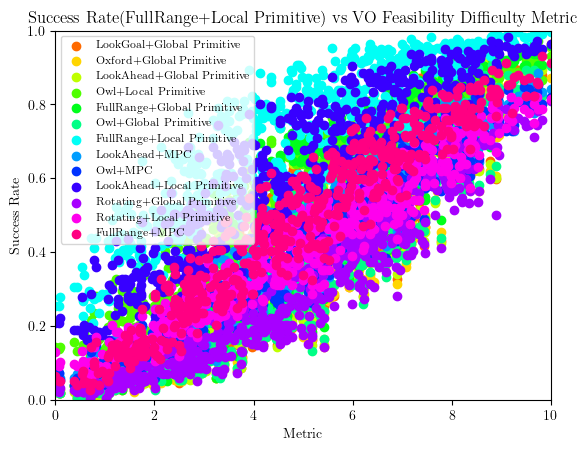

In [185]:
from scipy.stats import spearmanr
# Generate a unique color for each unique combination of 'Method' and 'Planner'
unique_method_planner = df_filtered['Method_Planner'].unique()
colors = sns.color_palette('hsv', len(unique_method_planner))
color_map = dict(zip(unique_method_planner, colors))
coefs = []

# Create a scatter plot for each unique combination of 'Method' and 'Planner'
for method_planner in unique_method_planner:
    df_plot = df_grouped[df_grouped['Method_Planner'] == method_planner]
    plt.scatter(df_plot['map difficulty'], df_plot['Success'], color=color_map[method_planner], label=method_planner)
    coef, p = spearmanr(df_plot['map difficulty'], df_plot['Success'])
    coefs.append(coef)

print(f"Average Spearman's rank correlation coefficient: {np.mean(coefs):.3f}")
print(f"std Spearman's rank correlation coefficient: {np.std(coefs):.3f}")
# Set the axis labels
plt.xlabel('Metric')
plt.ylabel('Success Rate')
plt.xlim(0, 10)
plt.ylim(0, 1)

# Set the title
plt.title('Success Rate(FullRange+Local Primitive) vs VO Feasibility Difficulty Metric')
# Show the legend
plt.legend(fontsize=8)
# plt.savefig('Success Rate(FullRange+Local Primitive) vs VO Feasibility Difficulty Metric.pdf')
# Show the plot
plt.show()


In [186]:
import matplotlib.patches as mpatches

colors_vel = sns.color_palette('hsv', 3)
color_map_vel = dict(zip([20, 40, 60], colors_vel))
coefs = {
    20:[],
    40:[],
    60:[]
}
for method_planner in unique_method_planner:
    df_plot = df_grouped[df_grouped['Method_Planner'] == method_planner]
    color_idx = df_plot.apply(lambda row: row['Agent speed'], axis=1).to_list()
    for speed in [20, 40, 60]:
        df_group = df_plot[df_plot['Agent speed'] == speed]
        coef, _ = spearmanr(10 - df_group['map difficulty'], df_group['Success'])
        coefs[speed].append(coef)
for key in coefs.keys():
    print(key, np.mean(coefs[key]), np.std(coefs[key]))

20 -0.9366496924658321 0.02100559580931423
40 -0.9533015010944289 0.005341330134857066
60 -0.9491772049374264 0.0036189075201012704


# Plot line chart with variance

In [187]:
grouped = df_filtered.groupby(['Method_Planner', 'round difficulty', *sort_columns])
df_grouped = grouped.agg({'Success': 'mean'}).reset_index()
grouped = df_grouped.groupby(['Method_Planner', 'round difficulty'])['Success']

# Create a DataFrame for results
df_results = pd.DataFrame({
    'Mean Success': grouped.mean(),
    'Variance Success': 0 if grouped.var() is None else grouped.var()
}).reset_index()
df_results = df_results.fillna(0)

Average Coefficient of Variation: 0.223
std Coefficient of Variation: 0.091
[0.3587195661263544, 0.2745369234858111, 0.3487000955039632, 0.13383556911315286, 0.3432220045121297, 0.3252355203908715, 0.10816037023816985, 0.16347600096593232, 0.170824224876777, 0.13447711176868257, 0.2258292737958859, 0.13843354030050223, 0.1734726705925376]


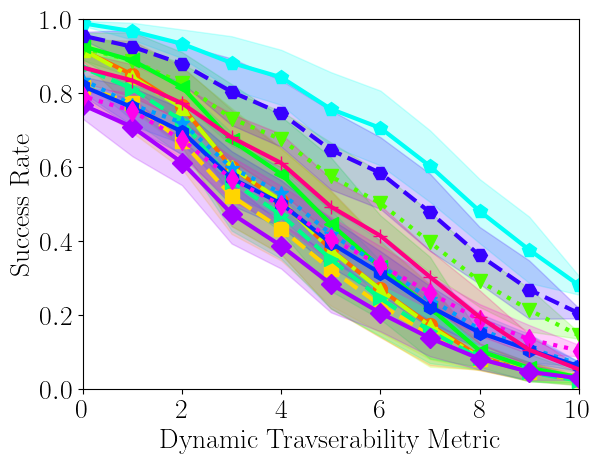

In [189]:
linestyles = ['-', '--', '-.', ':', '-', '--', '-', ':', '-', '--', '-', ':', '-']
markers = ['o', 's', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'D', 'd', '+']

colors = sns.color_palette('hsv', len(unique_method_planner))
color_map = dict(zip(unique_method_planner, colors))
cvs = []
for i, method_planner in enumerate(unique_method_planner):
    df_plot = df_results[df_results['Method_Planner'] == method_planner]
    plt.plot(10 - df_plot['round difficulty'].to_numpy(), df_plot['Mean Success'].to_numpy(), 
             color=color_map[method_planner], label=method_planner.replace('FullRange+',''),
             linestyle=linestyles[i],
             marker=markers[i],
             markersize=10,
             linewidth=3)
    
    # Here we create the shaded variance region
    plt.fill_between(10 - df_plot['round difficulty'], 
                     df_plot['Mean Success'] - np.sqrt(df_plot['Variance Success']), 
                     df_plot['Mean Success'] + np.sqrt(df_plot['Variance Success']), 
                     color=color_map[method_planner], alpha=0.2)
    # Compute coefficient of variation at each point
    cv = np.sqrt(df_plot['Variance Success']) / df_plot['Mean Success']
    
    # Calculate the average coefficient of variation for the curve
    avg_cv = np.mean(cv)
    cvs.append(avg_cv)

# Set the axis labels
print(f"Average Coefficient of Variation: {np.mean(cvs):.3f}")
print(f"std Coefficient of Variation: {np.std(cvs):.3f}")
print(cvs)
plt.xlabel('Dynamic Travserability Metric', fontsize=20)
plt.ylabel('Success Rate', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0, 1)
plt.xlim(0, 10)

# Set the title
title = 'Dense VO Feasibility Difficulty Metric'
# plt.title(r'\textbf{' + title + '}', fontsize=26)

# Show the legend
# plt.legend(fontsize=14, bbox_to_anchor=(0, 0), borderaxespad=0., ncol = 6)
# plt.savefig('/home/smoggy/thesis/ICRA-paper/img/Dynamic Traversability Difficulty Metric.pdf', bbox_inches='tight')
# Show the plot
plt.show()

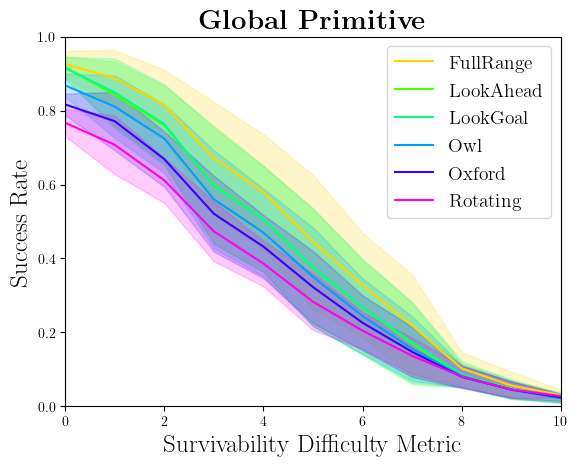

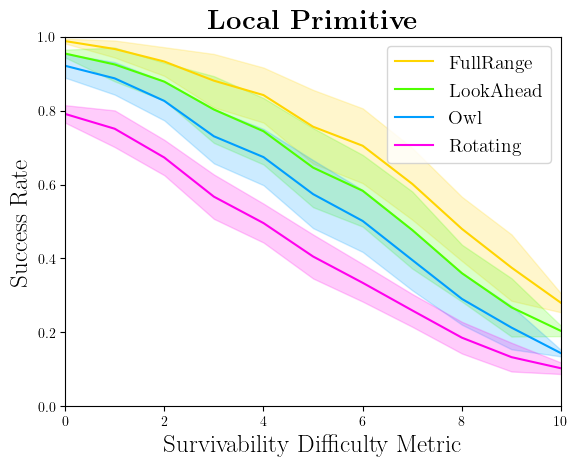

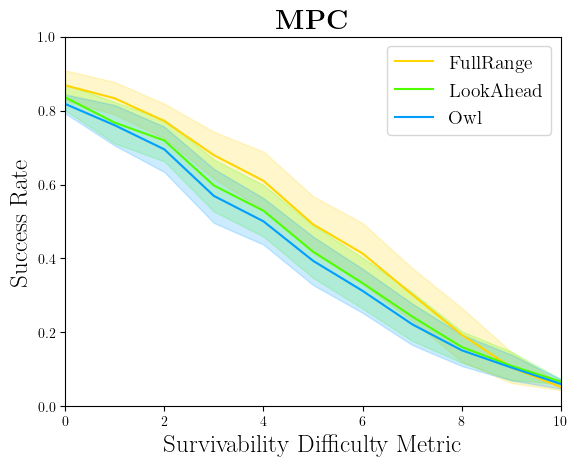

In [190]:


# Assuming df_results has a 'Planner' column
df_results[['Method','Planner']] = df_results['Method_Planner'].str.split('+', n=1, expand=True)
unique_planners = df_results['Planner'].unique()
unique_method = df_results['Method'].unique()
colors = sns.color_palette('hsv', len(unique_method))
color_map = dict(zip(unique_method, colors))
for planner in unique_planners:
    cvs = []
    
    plt.figure()  # Create a new figure for each planner
    
    # Filter data for the current planner
    df_planner = df_results[df_results['Planner'] == planner]
    
    for method in df_planner['Method'].unique():
        df_plot = df_planner[df_planner['Method'] == method]
        
        plt.plot(10 - df_plot['round difficulty'].to_numpy(), df_plot['Mean Success'].to_numpy(), 
                 color=color_map[method], label=method)
        plt.fill_between(10 - df_plot['round difficulty'].to_numpy(), 
                         df_plot['Mean Success'] - np.sqrt(df_plot['Variance Success']), 
                         df_plot['Mean Success'] + np.sqrt(df_plot['Variance Success']), 
                         color=color_map[method], alpha=0.2)
        

    # Set the axis labels
    plt.xlabel('Survivability Difficulty Metric', fontsize=18)
    plt.ylabel('Success Rate', fontsize=18)
    plt.ylim(0, 1)
    plt.xlim(0, 10)
    
    # Set the title
    title = f'{planner}: Dense VO Feasibility Difficulty Metric'
    plt.title(r'\textbf{' + planner + '}', fontsize=20)
    
    # Legend and display
    plt.legend(fontsize=14)
    # plt.savefig(f'./{planner}'+'_gaze_compare'+'.pdf', bbox_inches='tight')
    plt.show()

# Bar plot

In [191]:
import matplotlib.pyplot as plt
import numpy as np

label1 = 'velocity ratio'
label2 = 'Planner'
df_filtered = df[(df['Motion Profile'] == 'CVM') & (df['Planner']=='Local Primitive')].copy()    
df_filtered['velocity ratio'] = df_filtered['Agent speed'] / df_filtered['Drone speed']
grouped = df_filtered.groupby([label1, label2])
df_grouped = grouped.agg({'Success': 'mean', 'Dead Lock': 'mean'}).reset_index()

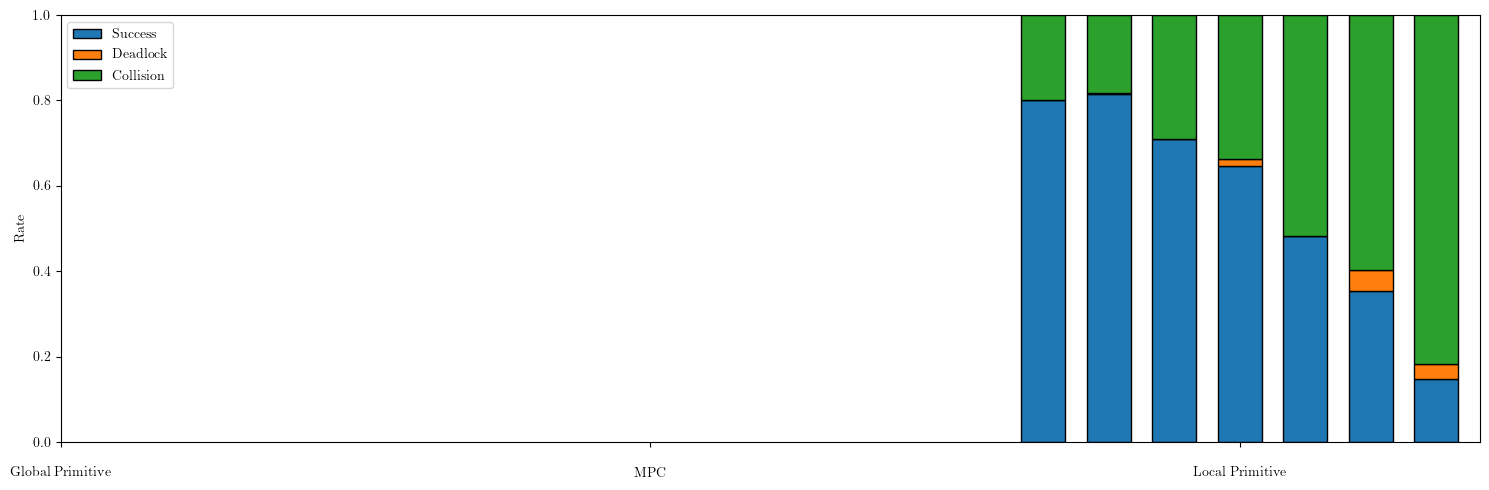

In [192]:
# Get the unique values of 'map difficulty' and 'Planner'
difficulties = df_grouped[label1].unique()
planners = df_grouped[label2].unique()
planners = ['Global Primitive', 'MPC', 'Local Primitive']

# Set the width of the bars and the distance between them
bar_width = 0.1
bar_distance = 0.2

# Set colors for success, deadlock, and collision
success_color = '#1f77b4'
deadlock_color = '#ff7f0e'
collision_color = '#2ca02c'

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(15, 5))

bar_positions = np.arange(len(planners)) * (len(difficulties) * bar_width + bar_distance)

for i, planner in enumerate(planners):
    # Filter the DataFrame for the current planner
    df_filtered = df_grouped[df_grouped[label2] == planner]

    # Generate positions for each group of bars
    bar_position = i * (len(difficulties) * bar_width + bar_distance)

    for j, difficulty in enumerate(difficulties):
        # Filter the DataFrame for the current difficulty
        df_filtered_difficulty = df_filtered[df_filtered[label1] == difficulty]
        
        # Calculate the mean values
        mean_success = df_filtered_difficulty['Success']
        mean_deadlock = df_filtered_difficulty['Dead Lock']

        # Create the bar plots
        bars_success = ax.bar(bar_position + j*bar_width, mean_success, width=2*bar_width/3, color=success_color, edgecolor='black')
        bars_deadlock = ax.bar(bar_position + j*bar_width, mean_deadlock, bottom=mean_success, width=2*bar_width/3, color=deadlock_color, edgecolor='black')
        bars_collision = ax.bar(bar_position + j*bar_width, 1 - mean_success - mean_deadlock, bottom=mean_success + mean_deadlock, width=2*bar_width/3, color=collision_color, edgecolor='black')

        # Add text annotations for agent velocity
        # velocity_text = f"{difficulty//10}"
        # ax.text(bar_position + j*bar_width + bar_width/2 - 0.05, -0.05, velocity_text, ha='center')
# Set the x-ticks to be the planners, and adjust their positions to be in the center of the grouped bars
ax.set_xticks(bar_positions + bar_width * (len(difficulties) - 1) / 2)
ax.set_xticklabels(planners)

# Set the tick label position to a lower position
ax.tick_params(axis='x', pad=15)
# ax.text(0, -0.06, 'Obstacle\nVelocities', ha='center')

# Set the axis labels and the title
ax.set_ylabel('Rate')
ax.set_ylim(0, 1)
# ax.set_title('Performance under different obstacle velocities' )

# Display the legend
ax.legend([bars_success, bars_deadlock, bars_collision], ['Success', 'Deadlock', 'Collision'])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()
# fig.savefig('planner_compare2.pdf')


# test for different speed

In [244]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.contrib.itertools import product

import pandas as pd
import glob
import os

df_metric = pd.read_csv('./experiment/metrics/survivability/metrics_test_vel.csv')
metrics = []
for i in range(45):
    metrics.append(df_metric['metric'][i])
data = np.array(metrics).flatten()
metric_dict_test_vel = {}
round_metrics_dict_test_vel = {}
index = 0

for (agent_num, agent_size, map_id) in product([10, 20, 30], [5, 10, 15], range(5)):
    metric_dict_test_vel[(map_id, agent_num, agent_size, -1, 'CVM')] = data[index]
    round_metrics_dict_test_vel[(map_id, agent_num, agent_size, -1, 'CVM')] = round(data[index])
    index += 1

for key in metric_dict_test_vel.keys():
    metric_dict_test_vel[key] = 10 * (metric_dict_test_vel[key] - min_value) / (max_value - min_value)
    # round_metrics_dict_test_vel[key] = round(metric_dict_test_vel[key], 2)  

# Path to the directory
directory_path_test_vel = './experiment/test/'

# Find all csv files in the path that starts with "results_test_vel"
all_files = glob.glob(os.path.join(directory_path_test_vel, "results_test_vel*.csv")) 

# Create an empty list to hold dataframes
df_list = []

# Loop over the list of files and read each into a dataframe and append to the list
for filename in all_files:
    df = pd.read_csv(filename)
    df_list.append(df)

# Concatenate all the dataframes in the list.
df_test_vel = pd.concat(df_list, ignore_index=True)
df_test_vel['Planner'] = df_test_vel['Planner'].replace({'Primitive' : 'Global Primitive', 'Jerk_Primitive': 'Local Primitive'})
df_test_vel['Method'] = df_test_vel['Method'].replace({'NoControl': 'FullRange'})

100%|██████████| 45/45 [00:00<00:00, 149559.18it/s]


In [245]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import itertools


df_filtered_test_vel = df_test_vel[df_test_vel['Motion Profile'] == 'CVM']
# Define the columns to sort by
sort_columns = ['Map ID', 'Number of agents', 'Agent size', 'Agent speed', 'Motion Profile']

# Add a new column to the dataframe for the combinations of 'Method' and 'Planner'
df_filtered_test_vel['Method_Planner'] = df_filtered_test_vel['Method'] + "+" + df_filtered_test_vel['Planner']
df_grouped_test_vel = df_filtered_test_vel.groupby(['Method_Planner', *sort_columns])['Success'].mean().reset_index()
df['round difficulty'] = [round_metrics_dict.get(tuple(x), 'N/A') for x in df[sort_columns].values]
df_grouped_test_vel['map difficulty'] = [metric_dict_test_vel.get(tuple(x), 'N/A') for x in df_grouped_test_vel[sort_columns].values]


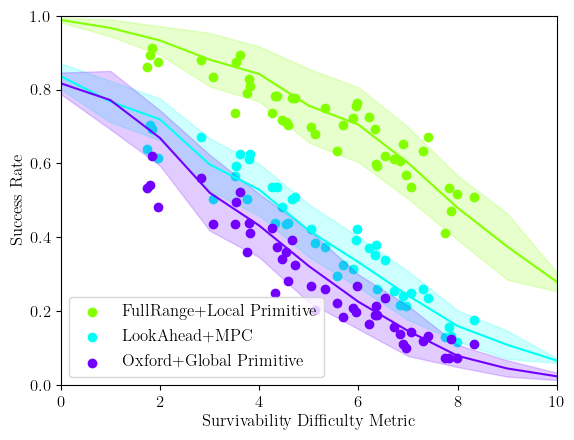

In [246]:
# Generate a unique color for each unique combination of 'Method' and 'Planner'
# unique_method_planner = df_filtered_test_vel['Method_Planner'].unique()
unique_method_planner = ['FullRange+Local Primitive', 'LookAhead+MPC', 'Oxford+Global Primitive']
colors = sns.color_palette('hsv', len(unique_method_planner))
color_map = dict(zip(unique_method_planner, colors))
# Configure matplotlib to use LaTeX font
plt.rc('font', family='serif', size=12)
plt.rc('text', usetex=True)
# Create a scatter plot for each unique combination of 'Method' and 'Planner'
for method_planner in unique_method_planner:
    df_plot = df_results[df_results['Method_Planner'] == method_planner]
    df_plot_test_vel = df_grouped_test_vel[df_grouped_test_vel['Method_Planner'] == method_planner]
    plt.scatter(10-df_plot_test_vel['map difficulty'], df_plot_test_vel['Success'], color=color_map[method_planner], label=method_planner)
    plt.plot(10-df_plot['round difficulty'].to_numpy(), df_plot['Mean Success'].to_numpy(), color=color_map[method_planner])
    plt.fill_between(10-df_plot['round difficulty'].to_numpy(), 
                     df_plot['Mean Success'] - np.sqrt(df_plot['Variance Success']), 
                     df_plot['Mean Success'] + np.sqrt(df_plot['Variance Success']), 
                     color=color_map[method_planner], alpha=0.2)

# Set the axis labels
plt.xlabel('Survivability Difficulty Metric')
plt.ylabel('Success Rate')
plt.xlim(0, 10)
plt.ylim(0, 1)

# Set the title
# plt.title('Scatter plot of Success Rate vs Data')

# Show the legend
plt.legend(loc='lower left')
# plt.savefig('/home/smoggy/thesis/paper/thesis/figures/vel_test.pdf', bbox_inches='tight')

# Show the plot
plt.show()

In [247]:
import numpy as np
from scipy.spatial import distance

def closest_distribution(difficulty, df):
    """Returns the row of the dataframe closest to the provided difficulty."""
    return df.iloc[(10 - df['round difficulty'] - difficulty).abs().argsort()[:1]]

mahalanobis_distances = []

# Loop over each unique combination of 'Method' and 'Planner'
for method_planner in unique_method_planner:
    df_plot = df_results[df_results['Method_Planner'] == method_planner]
    df_plot_test_vel = df_grouped_test_vel[df_grouped_test_vel['Method_Planner'] == method_planner].copy()

    for idx, row in df_plot_test_vel.iterrows():
        scatter_difficulty = 10-row['map difficulty']
        scatter_success = row['Success']

        # Find the closest distribution
        closest_dist = closest_distribution(scatter_difficulty, df_plot)
        mean_success = closest_dist['Mean Success'].values[0]
        variance_success = closest_dist['Variance Success'].values[0]

        # Calculate covariance matrix (since it's 1D, it's just the variance)
        cov_matrix = np.array([[variance_success]])

        # Calculate Mahalanobis distance for the scatter point
        mahalanobis_dist = distance.mahalanobis([scatter_success], [mean_success], np.linalg.inv(cov_matrix))
        mahalanobis_distances.append(mahalanobis_dist)

# Compute and print the average of all Mahalanobis distances
average_distance = np.mean(mahalanobis_distances)
print(len(mahalanobis_distances))
print(average_distance)


135
0.6321427646715909


In [248]:
# Count of points that fall within each sigma bound
count_1sigma, count_2sigma, count_3sigma = 0, 0, 0
for method_planner in unique_method_planner:
    df_plot = df_results[df_results['Method_Planner'] == method_planner]
    df_plot_test_vel = df_grouped_test_vel[df_grouped_test_vel['Method_Planner'] == method_planner]
    
    for index, row in df_plot_test_vel.iterrows():
        # Extract values from the dataframe
        difficulty = round(row['map difficulty'])
        success = row['Success']
        
        # Extract the corresponding mean and variance from df_plot
        df_selected = df_plot.loc[df_plot['round difficulty']==difficulty]
        mean_success = df_selected['Mean Success'].values[0]
        std_dev = np.sqrt(df_selected['Variance Success'].values[0])
        i += 1
        # Check if the success value is within each sigma bound
        if mean_success - std_dev <= success <= mean_success + std_dev:
            count_1sigma += 1
        if mean_success - 2*std_dev <= success <= mean_success + 2*std_dev:
            count_2sigma += 1
        if mean_success - 3*std_dev <= success <= mean_success + 3*std_dev:
            count_3sigma += 1

total_points = 135
percentage_1sigma = (count_1sigma / total_points) * 100
percentage_2sigma = (count_2sigma / total_points) * 100
percentage_3sigma = (count_3sigma / total_points) * 100

print(f"{percentage_1sigma}% of points lie within 1 sigma of the mean.")
print(f"{percentage_2sigma}% of points lie within 2 sigma of the mean.")
print(f"{percentage_3sigma}% of points lie within 3 sigma of the mean.")


76.29629629629629% of points lie within 1 sigma of the mean.
98.51851851851852% of points lie within 2 sigma of the mean.
100.0% of points lie within 3 sigma of the mean.


# test for different shaped

In [249]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.contrib.itertools import product

import pandas as pd
import glob
import os

df_metric = pd.read_csv('./experiment/metrics/survivability/metrics_size_validation.csv')
metrics = []
for i in range(45):
    metrics.append(df_metric['metric'][i])
data = np.array(metrics).flatten()
metric_dict_test_shape = {}
round_metrics_dict_test_shape = {}
index = 0

for (agent_num, agent_vel, map_id) in product([10, 20, 30], [20, 40, 60], range(5)):
    metric_dict_test_shape[(map_id, agent_num, -1, agent_vel, 'CVM')] = data[index]
    round_metrics_dict_test_shape[(map_id, agent_num, -1, agent_vel, 'CVM')] = round(data[index])
    index += 1

for key in metric_dict_test_shape.keys():
    metric_dict_test_shape[key] = 10*(metric_dict_test_shape[key]-min_value)/(max_value-min_value)

# Path to the directory
directory_path_test_shape = './experiment/test/'

# Find all csv files in the path that starts with "results_test_vel"
all_files = glob.glob(os.path.join(directory_path_test_shape, "results_test_size*.csv")) 

# Create an empty list to hold dataframes
df_list = []

# Loop over the list of files and read each into a dataframe and append to the list
for filename in all_files:
    df = pd.read_csv(filename)
    df_list.append(df)

# Concatenate all the dataframes in the list.
df_test_shape = pd.concat(df_list, ignore_index=True)
df_test_shape['Planner'] = df_test_shape['Planner'].replace({'Primitive' : 'Global Primitive', 'Jerk_Primitive': 'Local Primitive'})
df_test_shape['Method'] = df_test_shape['Method'].replace({'NoControl': 'FullRange'})

100%|██████████| 45/45 [00:00<00:00, 61964.44it/s]


In [250]:
df_filtered_test_shape = df_test_shape[df_test_shape['Motion Profile'] == 'CVM']
df_filtered_test_shape['Method_Planner'] = df_filtered_test_shape['Method'] + "+" + df_filtered_test_shape['Planner']

df_filtered_test_shape['map difficulty'] = df_filtered_test_shape.apply(lambda row: metric_dict_test_shape.get((row['Map ID'], row['Number of agents'], row['Agent size'], row['Agent speed'], row['Motion Profile']), 'N/A'), axis=1)
df_grouped_test_shape = df_filtered_test_shape.groupby(['Method_Planner', 'map difficulty'])['Success'].mean().reset_index()

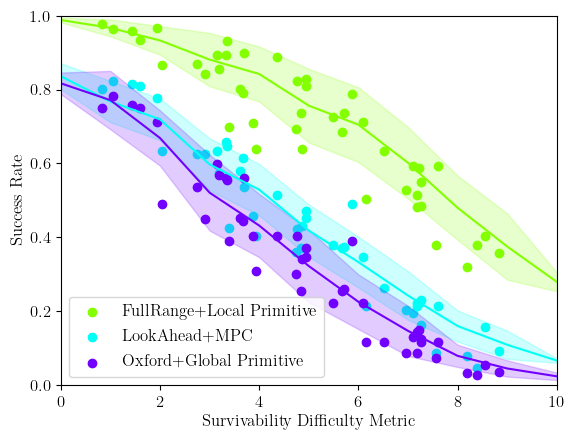

In [251]:
import seaborn as sns
# Generate a unique color for each unique combination of 'Method' and 'Planner'
unique_method_planner = df_grouped_test_shape['Method_Planner'].unique()
colors = sns.color_palette('hsv', len(unique_method_planner))
color_map = dict(zip(unique_method_planner, colors))

# Create a scatter plot for each unique combination of 'Method' and 'Planner'
for method_planner in unique_method_planner:
    df_plot = df_results[df_results['Method_Planner'] == method_planner]
    df_plot_test_shape = df_grouped_test_shape[df_grouped_test_shape['Method_Planner'] == method_planner]
    plt.scatter(10-df_plot_test_shape['map difficulty'].to_numpy(), df_plot_test_shape['Success'], color=color_map[method_planner], label=method_planner)
    plt.plot(10-df_plot['round difficulty'].to_numpy(), df_plot['Mean Success'].to_numpy(), color=color_map[method_planner])
    plt.fill_between(10-df_plot['round difficulty'].to_numpy(), 
                     df_plot['Mean Success'] - np.sqrt(df_plot['Variance Success']), 
                     df_plot['Mean Success'] + np.sqrt(df_plot['Variance Success']), 
                     color=color_map[method_planner], alpha=0.2)

# Set the axis labels
plt.xlabel('Survivability Difficulty Metric')
plt.ylabel('Success Rate')
plt.xlim(0, 10)
plt.ylim(0, 1)

# Set the title
# plt.title(r'\textbf{Scatter Plot of Survivability Metric and Success Rate in Maps with Various Obstacle Sizes}', fontsize=10)

# Show the legend
plt.legend()
# plt.savefig('test_size.pdf', bbox_inches='tight')

# Show the plot
plt.show()

In [252]:
import numpy as np
from scipy.spatial import distance

mahalanobis_distances = []

# Loop over each unique combination of 'Method' and 'Planner'
for method_planner in unique_method_planner:
    df_plot = df_results[df_results['Method_Planner'] == method_planner]
    df_plot_test_shape = df_grouped_test_shape[df_grouped_test_shape['Method_Planner'] == method_planner].copy()

    for idx, row in df_plot_test_shape.iterrows():
        scatter_difficulty = 10-row['map difficulty']
        scatter_success = row['Success']

        # Find the closest distribution
        closest_dist = closest_distribution(scatter_difficulty, df_plot)
        mean_success = closest_dist['Mean Success'].values[0]
        variance_success = closest_dist['Variance Success'].values[0]

        # Calculate covariance matrix (since it's 1D, it's just the variance)
        cov_matrix = np.array([[variance_success]])

        # Calculate Mahalanobis distance for the scatter point
        mahalanobis_dist = distance.mahalanobis([scatter_success], [mean_success], np.linalg.inv(cov_matrix))
        mahalanobis_distances.append(mahalanobis_dist)

# Compute and print the average of all Mahalanobis distances
average_distance = np.mean(mahalanobis_distances)
print(len(mahalanobis_distances))
print(average_distance)

135
0.7674493503609858


In [253]:
# Count of points that fall within each sigma bound
count_1sigma, count_2sigma, count_3sigma = 0, 0, 0
for method_planner in unique_method_planner:
    df_plot = df_results[df_results['Method_Planner'] == method_planner]
    df_plot_test_shape = df_grouped_test_shape[df_grouped_test_shape['Method_Planner'] == method_planner]
    
    for index, row in df_plot_test_shape.iterrows():
        # Extract values from the dataframe
        difficulty = round(row['map difficulty'])
        success = row['Success']
        
        # Extract the corresponding mean and variance from df_plot
        df_selected = df_plot.loc[df_plot['round difficulty']==difficulty]
        mean_success = df_selected['Mean Success'].values[0]
        std_dev = np.sqrt(df_selected['Variance Success'].values[0])
        i += 1
        # Check if the success value is within each sigma bound
        if mean_success - std_dev <= success <= mean_success + std_dev:
            count_1sigma += 1
        if mean_success - 2*std_dev <= success <= mean_success + 2*std_dev:
            count_2sigma += 1
        if mean_success - 3*std_dev <= success <= mean_success + 3*std_dev:
            count_3sigma += 1

total_points = 135
percentage_1sigma = (count_1sigma / total_points) * 100
percentage_2sigma = (count_2sigma / total_points) * 100
percentage_3sigma = (count_3sigma / total_points) * 100

print(f"{percentage_1sigma}% of points lie within 1 sigma of the mean.")
print(f"{percentage_2sigma}% of points lie within 2 sigma of the mean.")
print(f"{percentage_3sigma}% of points lie within 3 sigma of the mean.")

71.11111111111111% of points lie within 1 sigma of the mean.
94.81481481481482% of points lie within 2 sigma of the mean.
100.0% of points lie within 3 sigma of the mean.


# Testing with RVO

In [254]:
import matplotlib.pyplot as plt
import seaborn as sns

directory_path = "./experiment/validation/"
csv_files = [file for file in os.listdir(directory_path) if file.endswith(".csv")]
dataframes = []
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    dataframe = pd.read_csv(file_path)
    dataframes.append(dataframe)
df = pd.concat(dataframes, ignore_index=True)
df['Planner'] = df['Planner'].replace({'Primitive' : 'Global Primitive', 'Jerk_Primitive': 'Local Primitive'})
df['Method'] = df['Method'].replace({'NoControl': 'FullRange'})
df['round difficulty'] = [round_metrics_dict.get(tuple(x), 'N/A') for x in df[sort_columns].values]
df['map difficulty'] = [metric_dict.get(tuple(x), 'N/A') for x in df[sort_columns].values]

metrics = []
df_metric = pd.read_csv('./experiment/metrics/survivability/metrics_6m_12s_RVO.csv')
for i in range(20):
    metrics.append(ast.literal_eval(df_metric['metric'][i]))
data = np.array(metrics).flatten()
index = 0
for map_id in range(20):
    for (agent_num, agent_size, agent_vel) in product([10, 20, 30], [5, 10, 15], [20, 40, 60]):
        metric_dict[(map_id, agent_num, agent_size, agent_vel, 'RVO')] = 10 - 10 * (data[index] - min_value) / (max_value - min_value)
        round_metrics_dict[(map_id, agent_num, agent_size, agent_vel, 'RVO')] = metric_dict[(map_id, agent_num, agent_size, agent_vel, 'RVO')]
        index += 1

df_rvo = df[(df['Motion Profile'] == 'RVO')].copy()
df_rvo['map difficulty'] = df_rvo.apply(lambda row: (metric_dict.get((row['Map ID'], row['Number of agents'], row['Agent size'], row['Agent speed'], row['Motion Profile']), 'N/A')), axis=1)
df_rvo['Method_Planner'] = df_rvo['Method'] + '+' + df_rvo['Planner']
df_grouped_rvo = df_rvo.groupby(['Method_Planner', 'map difficulty', *sort_columns])['Success'].mean().reset_index()

100%|██████████| 27/27 [00:00<00:00, 346318.68it/s]


Average Spearman's rank correlation coefficient: nan
std Spearman's rank correlation coefficient: nan
[]


/home/smoggy/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/smoggy/.local/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/smoggy/.local/lib/python3.8/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/smoggy/.local/lib/python3.8/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/smoggy/.local/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


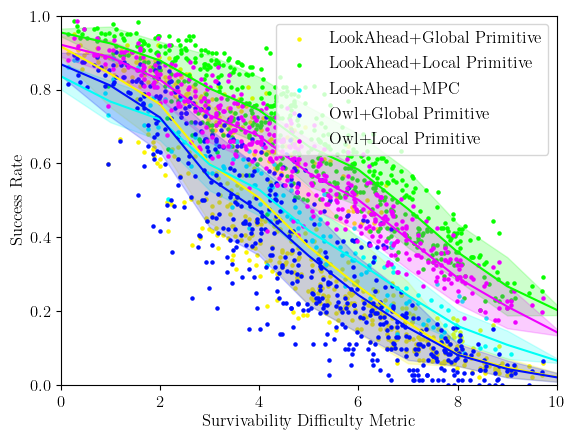

In [255]:
from scipy.stats import spearmanr
# Generate a unique color for each unique combination of 'Method' and 'Planner'
unique_method_planner = df_grouped_rvo['Method_Planner'].unique()
colors = sns.color_palette('hsv', len(unique_method_planner))
color_map = dict(zip(unique_method_planner, colors))

coefs = []

# Create a scatter plot for each unique combination of 'Method' and 'Planner'
for method_planner in unique_method_planner:
    df_plot = df_results[df_results['Method_Planner'] == method_planner]
    df_plot_rvo = df_grouped_rvo[df_grouped_rvo['Method_Planner'] == method_planner]
    plt.scatter(df_plot_rvo['map difficulty'].to_numpy(), df_plot_rvo['Success'].to_numpy(), color=color_map[method_planner], label=method_planner, s=5)
    plt.plot(10 - df_plot['round difficulty'].to_numpy(), df_plot['Mean Success'].to_numpy(), color=color_map[method_planner])
    plt.fill_between(10 - df_plot['round difficulty'].to_numpy(), 
                     df_plot['Mean Success'] - np.sqrt(df_plot['Variance Success']), 
                     df_plot['Mean Success'] + np.sqrt(df_plot['Variance Success']), 
                     color=color_map[method_planner], alpha=0.2)
    


print(f"Average Spearman's rank correlation coefficient: {np.mean(coefs):.3f}")
print(f"std Spearman's rank correlation coefficient: {np.std(coefs):.3f}")
print(coefs)
# Set the axis labels
plt.xlabel('Survivability Difficulty Metric')
plt.ylabel('Success Rate')
plt.xlim(0, 10)
plt.ylim(0, 1)

# Set the title
# plt.title('Success Rate(FullRange+Local Primitive) vs VO Feasibility Difficulty Metric')

# Show the legend
plt.legend()
# plt.savefig('/home/smoggy/thesis/paper/thesis/figures/test_rvo2.pdf', bbox_inches='tight')
# Show the plot
plt.show()

In [256]:
import numpy as np
from scipy.spatial import distance

mahalanobis_distances = []

# Loop over each unique combination of 'Method' and 'Planner'
for method_planner in unique_method_planner:
    df_plot = df_results[df_results['Method_Planner'] == method_planner]
    df_plot_rvo = df_grouped_rvo[df_grouped_rvo['Method_Planner'] == method_planner].copy()

    for idx, row in df_plot_rvo.iterrows():
        scatter_difficulty = row['map difficulty']
        scatter_success = row['Success']

        # Find the closest distribution
        closest_dist = closest_distribution(scatter_difficulty, df_plot)
        mean_success = closest_dist['Mean Success'].values[0]
        variance_success = closest_dist['Variance Success'].values[0]

        # Calculate covariance matrix (since it's 1D, it's just the variance)
        cov_matrix = np.array([[variance_success]])

        # Calculate Mahalanobis distance for the scatter point
        mahalanobis_dist = distance.mahalanobis([scatter_success], [mean_success], np.linalg.inv(cov_matrix))
        mahalanobis_distances.append(mahalanobis_dist)

# Compute and print the average of all Mahalanobis distances
average_distance = np.mean(mahalanobis_distances)
print(len(mahalanobis_distances))
print(average_distance)

2160
0.8194850022652495


In [257]:
# Count of points that fall within each sigma bound
count_1sigma, count_2sigma, count_3sigma = 0, 0, 0
for method_planner in unique_method_planner:
    df_plot = df_results[df_results['Method_Planner'] == method_planner]
    df_plot_rvo = df_grouped_rvo[df_grouped_rvo['Method_Planner'] == method_planner]
    
    for index, row in df_plot_rvo.iterrows():
        # Extract values from the dataframe
        difficulty = round(row['map difficulty'])
        success = row['Success']
        
        # Extract the corresponding mean and variance from df_plot
        df_selected = df_plot.loc[df_plot['map difficulty']==difficulty]
        mean_success = df_selected['Mean Success'].values[0]
        std_dev = np.sqrt(df_selected['Variance Success'].values[0])
        i += 1
        # Check if the success value is within each sigma bound
        if mean_success - std_dev <= success <= mean_success + std_dev:
            count_1sigma += 1
        if mean_success - 2*std_dev <= success <= mean_success + 2*std_dev:
            count_2sigma += 1
        if mean_success - 3*std_dev <= success <= mean_success + 3*std_dev:
            count_3sigma += 1

total_points = df_grouped_rvo.shape[0]
percentage_1sigma = (count_1sigma / total_points) * 100
percentage_2sigma = (count_2sigma / total_points) * 100
percentage_3sigma = (count_3sigma / total_points) * 100

print(f"{percentage_1sigma}% of points lie within 1 sigma of the mean.")
print(f"{percentage_2sigma}% of points lie within 2 sigma of the mean.")
print(f"{percentage_3sigma}% of points lie within 3 sigma of the mean.")

KeyError: 'map difficulty'

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
import ast
from tqdm.contrib.itertools import product

df_metric = pd.read_csv('experiment/metrics/survivability/metrics_6m_12s_CVM.csv')
# df_metric = pd.read_csv('experiment/metrics/traversibility/traversibility.csv')
metrics = []
for i in range(20):
    metrics.append(ast.literal_eval(df_metric['metric'][i]))
data = np.array(metrics).flatten()
metric_dict = {}
round_metrics_dict = {}
index = 0
for map_id in range(20):
    for (agent_num, agent_size, agent_vel) in product([10, 20, 30], [5, 10, 15], [20, 40, 60]):
        metric_dict[(map_id, agent_num, agent_size, agent_vel, 'CVM')] = data[index]
        index += 1

max_value = max(metric_dict.values())
min_value = min(metric_dict.values())

for key in metric_dict.keys():
    metric_dict[key] = 10 - 10 * (metric_dict[key] - min_value) / (max_value - min_value)
    round_metrics_dict[key] = round(metric_dict[key])

directory_path = "./experiment/validation/"

# Get all CSV file names in the directory
csv_files = [file for file in os.listdir(directory_path) if file.endswith(".csv")]
dataframes = []
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    dataframe = pd.read_csv(file_path)
    dataframes.append(dataframe)
df = pd.concat(dataframes, ignore_index=True)
df['Planner'] = df['Planner'].replace({'Primitive' : 'Global Primitive', 'Jerk_Primitive': 'Local Primitive'})
df['Method'] = df['Method'].replace({'NoControl': 'FullRange'})

sort_columns = ['Map ID', 'Number of agents', 'Agent size', 'Agent speed', 'Motion Profile']
df_filtered = df[(df['Motion Profile'] == 'CVM') ]
df_filtered['Parameters'] = df_filtered[sort_columns].apply(tuple, axis=1)
df_filtered['Method_Planner'] = df_filtered['Method'] + '+' + df_filtered['Planner']

grouped = df_filtered.groupby(['Method_Planner', 'Parameters'])
df_grouped = grouped.agg({'Success': 'mean', 'Dead Lock': 'mean'}).reset_index()

df_grouped['map difficulty'] = df_grouped.apply(lambda row: round_metrics_dict.get(row['Parameters'], 'N/A'), axis=1)


grouped = df_grouped.groupby(['Method_Planner', 'map difficulty'])['Success']
grouped_deadlock = df_grouped.groupby(['Method_Planner', 'map difficulty'])['Dead Lock']
mean_success = grouped.mean()
var_success = grouped.var()
mean_deadlock = grouped_deadlock.mean()
var_deadlock = grouped_deadlock.var()


# Create a DataFrame for results
df_results = pd.DataFrame({
    'Mean Success': mean_success,
    'Variance Success': 0 if var_success is None else var_success,
    'Mean Deadlock': mean_deadlock,
    'Variance Deadlock': var_deadlock
}).reset_index()
df_results = df_results.fillna(0)

# Plot mean success rate and variance for each 'Method_Planner'
from scipy.stats import variation
import matplotlib as mpl

# Set the global font to be DejaVu Sans, size 10 (or any other sans-serif font of your choice)
mpl.rc('text', usetex=True)
# Define the font size
mpl.rc('font', size=18)  # controls default text sizes
mpl.rc('axes', titlesize=20)  # fontsize of the axes title
mpl.rc('axes', labelsize=18)  # fontsize of the x and y labels
mpl.rc('xtick', labelsize=16)  # fontsize of the tick labels
mpl.rc('ytick', labelsize=16)  # fontsize of the tick labels
mpl.rc('legend', fontsize=16)  # legend fontsize
mpl.rc('figure', titlesize=3)  # fontsize of the figure title

# plt.figure(figsize=(16, 10))

cvs = []
unique_method_planner = [('FullRange+Local Primitive'), ('LookAhead+MPC'), ('Oxford+Global Primitive')]
# Generate a unique color for each unique combination of 'Method' and 'Planner'
# unique_method_planner = df_filtered['Method_Planner'].unique()
colors = sns.color_palette('hsv', len(unique_method_planner))
color_map = dict(zip(unique_method_planner, colors))



In [ ]:
directory_path = './experiment/discussion/'
csv_files = [file for file in os.listdir(directory_path) if file.endswith(".csv")]
dataframes = []
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    dataframe = pd.read_csv(file_path)
    dataframes.append(dataframe)
df = pd.concat(dataframes, ignore_index=True)
df['Planner'] = df['Planner'].replace({'Primitive' : 'Global Primitive', 'Jerk_Primitive': 'Local Primitive'})
df['Method'] = df['Method'].replace({'NoControl': 'FullRange'})

sort_columns = ['Map ID', 'Number of agents', 'Agent size', 'Agent speed', 'Motion Profile']
df_filtered = df[(df['Motion Profile'] == 'CVM') ]
df_filtered['Parameters'] = df_filtered[sort_columns].apply(tuple, axis=1)
df_filtered['Method_Planner'] = df_filtered['Method'] + '+' + df_filtered['Planner']

grouped = df_filtered.groupby(['Method_Planner', 'Parameters'])
df_grouped = grouped.agg({'Success': 'mean', 'Dead Lock': 'mean'}).reset_index()
points = []
for i in df_grouped.index:
    row = df_grouped.loc[i]
    planner = row['Method_Planner']
    difficulty = 5
    success = row['Success']
    points.append((planner, difficulty, success))

In [ ]:
for method_planner in unique_method_planner:
    df_plot = df_results[df_results['Method_Planner'] == method_planner]
    plt.plot(df_plot['map difficulty'], df_plot['Mean Success'], 
             color=color_map[method_planner], label=method_planner)
    
    # Here we create the shaded variance region
    plt.fill_between(df_plot['map difficulty'], 
                     df_plot['Mean Success'] - np.sqrt(df_plot['Variance Success']), 
                     df_plot['Mean Success'] + np.sqrt(df_plot['Variance Success']), 
                     color=color_map[method_planner], alpha=0.2)
for point in points:
    plt.scatter(point[1], point[2], color=color_map[point[0]])

# Set the axis labels
print(f"Average Coefficient of Variation: {np.mean(cvs):.3f}")
print(f"std Coefficient of Variation: {np.std(cvs):.3f}")
print(cvs)
plt.xlabel('VO Feasibility Metric(dense sample)', fontsize=22)
plt.ylabel('Success Rate', fontsize=22)
plt.ylim(0, 1)
plt.xlim(0, 10)

# Set the title
title = 'Dense VO Feasibility Difficulty Metric'
plt.title(r'\textbf{' + title + '}', fontsize=26)

# Show the legend
plt.legend(fontsize=14)
# plt.savefig('/home/smoggy/thesis/paper/thesis/figures/' + title+'.pdf', bbox_inches='tight')
# Show the plot
plt.show()